# Projet SAV
Binôme: Halimi Abdelghani ; Hadjadj Ahmed
# But du projet
Le but de ce projet est de parvenir à classer des images de plaques de signalisations suivant trois classes : (Multiclass classification)

- Les panneaux d’avertissement de danger.
- Les panneaux d’interdiction ou de restriction.
- Les panneaux d’obligation

Et cela en utilisant deux méthodes :
- En utilisant l’algorithme du k-plus proches voisins (KNN).
- En utilisant un réseau neuronal multicouche (ANN).


# Importation des bibliotèques

In [1]:
import pandas as pd
import numpy as np
import os
import cv2 
from  matplotlib import pyplot as plt
from skimage.feature import hog
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split 

***
# Phase de prétraitement:
***

- Appliquer un filtre médian pour la réduction des bruits impultionelles dans les images.
- Conversion de l’espace RGB vers l’espace Y’CbCr.
- Redimentionement des images (128,64).
- Calcul de l'histogramme des gradients orientés pour chacune des images 

**NB:** Pas la peine de normaliser nos images par 255 car c'est inclut dans le calcul du HOG (Valeurs comprises entre 0 et 1 => calculs moins complexes dans le réseau neuronal)

In [2]:
IMG_WIDTH=128
IMG_HEIGHT=64 
img_folder=r'C:\\Data'

**NB**: img_folder prend la destination du dossier qui a nos 3 dossiers des classes. (dossier Data contient 3 dossiers: classe avertissement de danger, classe interdiction ou restriction et classe obligation)

#### Fonction de la conversion de l’espace RGB vers l’espace Y’CbCr

tels que : 
$$
𝑌′ =0.299𝑅+0.587𝐺+0.114𝐵 
$$
$$
𝐶_𝑏 =−0.1687𝑅−0.3313𝐺+0.5𝐵+128 
$$
$$
𝐶_𝑟  =0.5𝑅−0.4187𝐺−0.0813𝐵+128
$$

In [3]:
def rgb2ycbcr(im):
    xform = np.array([[.299, .587, .114], [-.1687, -.3313, .5], [.5, -.4187, -.0813]])
    ycbcr = im.dot(xform.T)
    ycbcr[:,:,[1,2]] += 128
    return np.uint8(ycbcr)

#### Création de notre dataset des images aprés prétraitement 

In [4]:
def create_dataset(img_folder):
   
    img_data_array=[]
    class_name=[]
   
    for dir1 in sorted(os.listdir(img_folder)):
        for file in sorted(os.listdir(os.path.join(img_folder, dir1))):
            image= os.path.join(img_folder, dir1,  file)
            image= cv2.imread(image)
            if image is not None:
                image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
                image= cv2.medianBlur(image, 3)
                image = rgb2ycbcr(image)
                image=cv2.resize(image, (IMG_HEIGHT, IMG_WIDTH))
                image=np.array(image)
                image = image.astype('float32')
                img_data_array.append(image)
                class_name.append(dir1)
    return img_data_array, class_name
# extract the image array and class name
images_traitées, class_name =create_dataset(img_folder)

In [5]:
np.shape(images_traitées)

(150, 128, 64, 3)

Affichage d'une image dans chacune des classes après traitement (dans la base YCbCr)

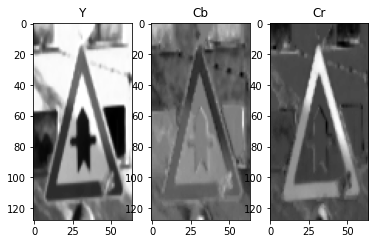

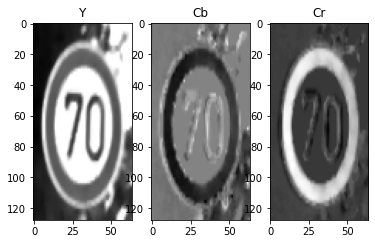

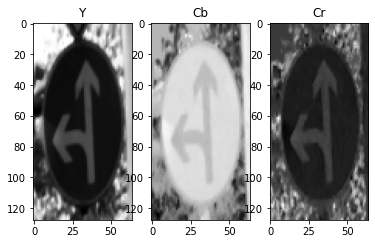

-1

In [6]:
channels = cv2.split(images_traitées[3])
plt.subplot(1,3,1),plt.imshow(channels[0],cmap = 'gray'),plt.title("Y")
plt.subplot(1,3,2),plt.imshow(channels[1],cmap = 'gray'),plt.title("Cb")
plt.subplot(1,3,3),plt.imshow(channels[2],cmap = 'gray'),plt.title("Cr")
plt.show()
channels2 = cv2.split(images_traitées[70])
plt.subplot(1,3,1),plt.imshow(channels2[0],cmap = 'gray'),plt.title("Y")
plt.subplot(1,3,2),plt.imshow(channels2[1],cmap = 'gray'),plt.title("Cb")
plt.subplot(1,3,3),plt.imshow(channels2[2],cmap = 'gray'),plt.title("Cr")
plt.show()
channels3 = cv2.split(images_traitées[130])
plt.subplot(1,3,1),plt.imshow(channels3[0],cmap = 'gray'),plt.title("Y")
plt.subplot(1,3,2),plt.imshow(channels3[1],cmap = 'gray'),plt.title("Cb")
plt.subplot(1,3,3),plt.imshow(channels3[2],cmap = 'gray'),plt.title("Cr")
plt.show()
cv2.waitKey(0)

#### Nos 3 classes:

In [7]:
target_dict={k: v for v, k in enumerate(np.unique(class_name))}
target_dict

{'classe avertissement de danger': 0,
 'classe interdiction ou restriction': 1,
 'classe obligation': 2}

In [8]:
target_val=  [target_dict[class_name[i]] for i in range(len(class_name))]

#### 4. Génération de caractéristiques

Calcul de l'histogramme des gradients orientés pour chacune des images

In [9]:
def HOG(images):
    hog_i = []
    vc= []
    for img in images:
        fv, hog_image = hog(img, orientations=9, pixels_per_cell=(8, 8),cells_per_block=(2, 2), visualize=True, multichannel=True)
        if fv is not None:
            vc.append(fv)
        if  hog_image is not None:
            hog_i.append(hog_image)
    return vc, hog_i

In [10]:
fv, hog_image=HOG(images_traitées)
np.shape(fv)

(150, 3780)

#### Donc la taille du vecteur caractéristique obtenu pour chaque image est de 3780

In [11]:
np.shape(hog_image)

(150, 128, 64)

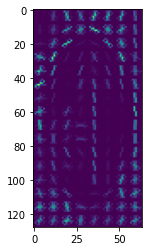

In [12]:
plt.imshow(hog_image[130])

In [13]:
fv = pd.DataFrame(fv)
target_val = np.array(target_val)
fv

,0,1,2,3,4,5,6,7,8,9,...,3770,3771,3772,3773,3774,3775,3776,3777,3778,3779
0,0.170426,0.000000,0.010509,0.000000,0.003054,0.005037,0.287398,0.349287,0.033699,0.402552,...,0.281899,0.429994,0.019590,0.000000,0.041148,0.057687,0.000000,0.000000,0.000000,0.429994
1,0.194230,0.010624,0.024353,0.045435,0.125289,0.083547,0.075094,0.341454,0.232796,0.341454,...,0.389883,0.168620,0.000000,0.038201,0.008275,0.128764,0.066497,0.261858,0.322760,0.048145
2,0.048966,0.013012,0.024071,0.007404,0.014548,0.004337,0.010973,0.028716,0.012011,0.068424,...,0.060487,0.293280,0.074039,0.045012,0.019403,0.103125,0.046107,0.094264,0.054810,0.293280
3,0.033914,0.034079,0.107719,0.061886,0.229310,0.117150,0.173669,0.236922,0.008990,0.267889,...,0.080457,0.110720,0.000000,0.019814,0.005373,0.185411,0.089580,0.274510,0.248674,0.000000
4,0.311338,0.192491,0.157222,0.083733,0.046886,0.028674,0.035172,0.029708,0.197392,0.201484,...,0.070257,0.357857,0.042074,0.002176,0.003441,0.064744,0.011720,0.031850,0.039562,0.349298
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,0.156766,0.104249,0.129389,0.137117,0.130457,0.085958,0.100687,0.066420,0.035093,0.335065,...,0.047212,0.218794,0.056333,0.041405,0.169011,0.245095,0.146814,0.245095,0.144652,0.047212
146,0.289824,0.029482,0.055937,0.029482,0.158215,0.029482,0.149166,0.124557,0.125080,0.289824,...,0.249887,0.249887,0.037603,0.125520,0.249887,0.239636,0.055172,0.214501,0.160150,0.163116
147,0.245280,0.187673,0.038062,0.006018,0.048445,0.012036,0.003806,0.032865,0.000000,0.312546,...,0.160033,0.180399,0.103229,0.122415,0.069863,0.248139,0.062304,0.065288,0.157746,0.214424
148,0.095242,0.000000,0.000000,0.000000,0.143877,0.004531,0.002866,0.016338,0.166994,0.320124,...,0.308258,0.241768,0.015181,0.000000,0.000000,0.034621,0.000000,0.005971,0.308258,0.308258


#### 5. Division des données de chaque classe aléatoirement en 2 ensembles 

20% pour l’ensemble apprentissage (référence) et 80% pour l’ensemble test.

In [14]:
(fv_train, fv_test, target_train, target_test) = train_test_split(fv, target_val,test_size=0.8, random_state=8)

- Si on prend les proportions données par la fascicule du projet (2/3 pour l’ensemble apprentissage (référence) et 1/3 pour l’ensemble test) ou même plus petite que 80% pour l'ensemble du test on aura que la précision lors du test est toujours égale à 1 pour le KNN et le ANN.

**NB**: si on n'a pas fixé le random_state d'autres précisions aurait étaient trouvées pour chaque exécution, mais on prefère le fixer car ça facilite le debugage du code ainsi que pour retrouver les mêmes resultats.

In [15]:
print("Le nombre d'échantillon d'entrainement = ",fv_train.shape)
print("Le nombre d'échantillon de test = ",fv_test.shape)

Le nombre d'échantillon d'entrainement =  (30, 3780)
Le nombre d'échantillon de test =  (120, 3780)


***
# Classification des images
***

# 6. K-plus proches voisins (KNN)

Avec "K" le nombre de voisins et "metric" le type de distance choisie:

- Distance Manhattan (p=1):
    $$
        D(a,b) = \sum^n_{i=1}|a_i - b_i|
    $$
- Distance Euclidienne (p=2):
    $$
        D(a,b) = sqrt(\sum^n_{i=1}|a_i - b_i|^2)
    $$
- Distance Canberra :
    $$
        D(a,b) = \sum^n_{i=1}\frac{|a_i-b_i|}{|a_i+b_i|}
    $$

Par exemple si on choisi 1 voisin (K=1) et la distance Manhattan (p=1)

In [16]:
classifier = KNeighborsClassifier(n_neighbors = 1, metric="manhattan")
classifier.fit(fv_train, target_train)

KNeighborsClassifier(metric='manhattan', n_neighbors=1)

In [17]:
y_pred = classifier.predict(fv_test)

In [18]:
print("La précision lors de l'entrainement : ",metrics.accuracy_score(target_train, classifier.predict(fv_train)))
print("La précision lors du test : ",metrics.accuracy_score(target_test, y_pred))

La précision lors de l'entrainement :  1.0
La précision lors du test :  0.9583333333333334


#### Observons maintenant l’influence de la distance choisie (Manhattan, Euclidienne et Canberra) en fonction de k (k=1,3,5,7 et 9)

In [19]:
Accuracy = []
for k in range(1,10,2) :
    for i in  ["manhattan", "euclidean", "canberra"]: 
        classifier = KNeighborsClassifier(n_neighbors = k, metric= i).fit(fv_train, target_train)
        y_pred = classifier.predict(fv_test)
        Accuracy.append(metrics.accuracy_score(target_test, y_pred))
print(Accuracy)

[0.9583333333333334, 0.9666666666666667, 0.9166666666666666, 0.95, 0.925, 0.8666666666666667, 0.9416666666666667, 0.9166666666666666, 0.875, 0.9083333333333333, 0.8916666666666667, 0.8583333333333333, 0.9166666666666666, 0.8916666666666667, 0.8416666666666667]


#### Remarques:

- On constate que l'ajout de voisins impactent négativement la précision de notre classifieur.

- On remarque aussi que la meilleure précision a été au niveau de la deuxième mesure qui correspond à 1 voisin et l'utilisation de la distance Euclidienne avec une précision d'environ 96,67%, faisant de cette distance le choix approprié à ce problème.

On prend donc ce cas pour le calcul de la matrice de confusion.



In [20]:
from sklearn.metrics import confusion_matrix,classification_report
classifier = KNeighborsClassifier(n_neighbors = 1, p = 2).fit(fv_train, target_train)
y_pred = classifier.predict(fv_test)
cm = confusion_matrix(target_test, y_pred)
print(classification_report(target_test, y_pred))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00        44
           1       0.90      1.00      0.95        38
           2       1.00      0.89      0.94        38

    accuracy                           0.97       120
   macro avg       0.97      0.96      0.96       120
weighted avg       0.97      0.97      0.97       120



In [21]:
print("Matrice de confusion : \n", cm)

Matrice de confusion : 
 [[44  0  0]
 [ 0 38  0]
 [ 0  4 34]]


**Calculons d'abord FN FP TP TN des 3 classes depuis la matrice de confusion:**

FN : La valeur "False-negative" d'une classe sera la somme des valeurs des lignes correspondantes, à l'exception de la valeur TP.

FP : La valeur des "False-positive" pour une classe sera la somme des valeurs de la colonne correspondante sauf pour la valeur TP.

TN : La valeur "True Negative" pour une classe sera la somme des valeurs de toutes les colonnes et les lignes sauf les valeurs de cette classe pour laquelle nous calculons les valeurs.

'classe avertissement de danger': 0   => FN=0, FP=0, TP=44, TN=76

 'classe interdiction ou restriction': 1  => FN=0, FP=4, TP=38, TN=78
 
 'classe obligation': 2  =>  FN=4, FP=0, TP=34, TN=82

D'après la matrice de confusion précédente on constate les choses suivantes :
- La classe des plaques d'avertissement a été parfaitement classée (FN=0 FP=0) et cela s'explique par le fait qu'elle a une forme différente des deux autres classes (avertissement : triangle, le reste : rond), ce qui a permi d'avoir une classification efficace.
- La classe des plaques d'interdiction et des plaques d'obligation ont globalement été très bien classées (la classe d'interdiction a été parfaitement classée FN=0)
- Dans la classe d'obligation on a 4 faux négatifs qui ont été classés parmis les plaques d'interdiction et ceci s'explique par le fait que les deux classes de panneaux ont la même formes, et que le modele n'a pas pu les classer correctement juste a partir de leurs couleurs (le changement de bases de couleurs dans ce cas n'a pas été assez efficace pour que le modèle puisse différencier la couleur bleu des plaques d'obligation de la couleur rouge des plaques d'interdiction et de les classer correctement).


# 7. Réseau de neurones multicouche

Depuis la librairie scikitlearn on importe MLPCassifier qui est un réseaux de neurones multicouches, ses arguments sont:
- "solver" est l'algorithme d'optimisation des poids (dans ce cas c'est demontré que lbfgs est bien meilleur que adam).
- "alpha" qui est le paramêtre de regularisation pour éviter le sur-apprentissage.
- "random_state" pour avoir les mêmes résultats lorsque on réexecute.
Et le nombre de couches cachées ainsi que le nombre de neuronnes dans les couches cachées, pour ce problème une couche cachée suffira, il reste donc a determiner le nombre de neuronnes dans cette couche.

**NB**: on sait aussi que le nombre de neuronne pour la couche d'entrée est égale à 3780 et celle de la couche de sortie égale à 3.

In [22]:
from sklearn.neural_network import MLPClassifier
accuracy_train = []
accuracy_test = []
for i in range(1,8) :
    modele = MLPClassifier(solver='lbfgs', alpha=1e-3, hidden_layer_sizes=(
        i), random_state=8, early_stopping=True).fit(fv_train, target_train)
    accuracy_train.append(metrics.accuracy_score(target_train, modele.predict(fv_train)))
    accuracy_test.append(modele.score(fv_test,target_test))
print(accuracy_train)
print(accuracy_test)


[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
[0.9416666666666667, 0.9916666666666667, 1.0, 0.9916666666666667, 1.0, 1.0, 1.0]


D'apres ces résultats on constate que:
- la précision pour notre ensemble d'apprentissage est égale à 1 pour tous les cas.
- les meilleurs résultats ont étaient trouvés avec 3,5,6 et 7 neurones (accuracy_train=accuracy_test=1), on prend donc le choix de 3 neurones (nombre minimal de neurones pour avoir: accuracy_train=accuracy_test=1).

In [23]:
modele = MLPClassifier(solver='lbfgs', alpha=1e-3, hidden_layer_sizes=(3),
                       random_state=8,early_stopping=True).fit(fv_train, target_train)

In [24]:
print("La précision lors de l'entrainement : ",
      metrics.accuracy_score(target_train, modele.predict(fv_train)))
print("La précision lors du test : ", modele.score(fv_test, target_test))


La précision lors de l'entrainement :  1.0
La précision lors du test :  1.0


On voit ainsi la puissance du réseau de neurones multicouche, donnant des résultats bien plus meilleurs que ceux trouvés avec l'algorithme K-plus proche voisin, avec le même dataset d'entrainement et de test. 

On voit maintenant la matrice de confusion de notre modèle

In [25]:
y_pred = modele.predict(fv_test)
print("Matrice de confusion : \n",metrics.confusion_matrix(target_test, y_pred))

Matrice de confusion : 
 [[44  0  0]
 [ 0 38  0]
 [ 0  0 38]]


On voit effectivement ici une classification parfaite de nos images dans les trois classes comme il le faut. Faisant ainsi de cette méthode, une méthode plus puissante que la précédente dans la classification des images. 

#### 8. Comparaison des deux méthodes de classification :

-En terme de précision et de puissance, il est clair que le réseaux de neurones multicouche est bien meilleur.

-En ce qui concerne la simplicité de l'algorithme, l'algorithme du K-plus proches voisins est plus simple et donc  plus facile à implémenter et donne d'assez bons résultats qu'on peut aisément améliorer avec un dataset plus large.

-En définitif dans des problemes de classifications simples comme notre cas dans ce projet, le choix d'un algorithme simple comme K-plus proches voisins est efficace, on opte néanmoins pour l'utilisation d'un réseau de neurones nous donnant une précision parfaite sur le dataset utilisé. 

#### 9. La mal classification n'a eu lieu qu'avec le KNN, donc d'après la matrice de confusion de l'algorithme KNN: 

In [26]:
print("Matrice de confusion : \n",cm)

Matrice de confusion : 
 [[44  0  0]
 [ 0 38  0]
 [ 0  4 34]]


Les images qui ont étaient mal classées sont 4 et elles appartiennent toutes à la classe d'obligation (au lieu d'être classées dans la classe d'obligation ils ont été classées parmis les plaques d'interdiction).

#### La mal classification des images s'expliquent comme suit :
- Le fait que les deux classes de panneaux ont la même formes (le modèle n'a pas pu différencier la couleur bleu des plaques d'obligation de la couleur rouge des plaques d'interdiction).
- La qualité des images qui est assez faible.
- Impact de la couleur de fond 

#### 10. Propositions/suggestions pour améliorer les performances atteintes
Pour les deux méthodes KNN et RNM:

- Augmentation du nombres d'images dans le dataset pour l'entrainement et le test.
- Utilisation d'images de meilleure qualité.

Pour le RNM:

- Augmentation du nombre d'itérations, de couches cachées ainsi que le nombre de neuronnes dans ces couches cachées.
- Utiliser des techniques pour éviter le sur-apprentissage tels que: dropout, régularisation L1 et L2, image augmentation.
